Notes:
 * revised and tuned configuration, updated views
 * training on full dataset (including Y3, new light curves, fixes)
 * trained with updated star radius estimations, multiple duplicates removed

In [61]:
import os

chkpt_root = '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1'
data_files = '/mnt/tess/astronet/tfrecords-34-val/*'
tces_file = '/mnt/tess/astronet/tces-v11-val.csv'

nruns = 10

def load_ensemble(chkpt_root, nruns):
    checkpts = []
    for i in range(nruns):
        parent = os.path.join(chkpt_root, str(i + 1))
        if not os.path.exists(parent):
            break
        all_dirs = os.listdir(parent)
        if not all_dirs:
            break
        d, = all_dirs
        checkpts.append(os.path.join(parent, d))
    return checkpts

paths = load_ensemble(chkpt_root, nruns)
paths

['/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/1/AstroCNNModel_revised_tuned_20220210_020018',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/2/AstroCNNModel_revised_tuned_20220210_020618',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/3/AstroCNNModel_revised_tuned_20220210_021215',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/4/AstroCNNModel_revised_tuned_20220210_021815',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/5/AstroCNNModel_revised_tuned_20220210_022416',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/6/AstroCNNModel_revised_tuned_20220210_023018',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/7/AstroCNNModel_revised_tuned_20220210_023626',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/8/AstroCNNModel_revised_tuned_20220210_024232',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/9/AstroCNNModel_revised_tuned_20220210_024838',
 '/mnt/tess/astronet/checkpoints/revised_tuned_34_run_1/10/Astro

In [62]:
import getpass
import os
from astronet import predict
import tensorflow as tf


def run_predictions(path):
    predict.FLAGS = predict.parser.parse_args([
      '--model_dir', path,
      '--data_files', data_files,
      '--output_file', '',
    ])

    return predict.predict()


paths = load_ensemble(chkpt_root, nruns)
ensemble_preds = []
config = None
for i, path in enumerate(paths):
    print(f'Running model {i + 1}')
    preds, config = run_predictions(path)
    ensemble_preds.append(preds.set_index('tic_id'))
    print()

Running model 1
2484 records
Running model 2
2484 records
Running model 3
2484 records
Running model 4
2484 records
Running model 5
2484 records
Running model 6
2484 records
Running model 7
2484 records
Running model 8
2484 records
Running model 9
2484 records
Running model 10
2484 records


In [63]:
labels = ['disp_e', 'disp_n', 'disp_j', 'disp_s', 'disp_b']

col_e = labels.index('disp_e')
thresh = 0.999

In [64]:
import numpy as np
import pandas as pd

agg_preds = {}

for preds in ensemble_preds:
    for tic_id in preds.index:
        if tic_id not in agg_preds:
            agg_preds[tic_id] = []

        row = preds[preds.index == tic_id]
        pred_v = row.values[0]
        if len(row.values) > 1:
            print(f'Warning: duplicate predictions for {tic_id}')
        if pred_v[col_e] >= thresh:
            agg_preds[tic_id].append('disp_e')
        else:
            masked_v = [v if i != col_e else 0 for i, v in enumerate(pred_v)]
            agg_preds[tic_id].append(preds.columns[np.argmax(masked_v)])

In [65]:
final_preds = []
for tic_id in list(agg_preds.keys()):
    counts = {l: 0 for l in labels}
    for e in agg_preds[tic_id]:
        counts[e] += 1
    maxcount = max(counts.values())
    counts.update({
        'tic_id': tic_id,
        'maxcount': maxcount,
    })
    final_preds.append(counts)
    
final_preds = pd.DataFrame(final_preds).set_index('tic_id')

In [66]:
tce_table = pd.read_csv(tces_file, header=0).set_index('tic_id')
for l in labels:
    tce_table[l] = tce_table[l[:-1] + l[-1].upper()]
tce_labels = tce_table[labels]

pl = final_preds.join(tce_labels, on='tic_id', how='left', lsuffix='_p')

pl.head()
pd.set_option('display.max_columns', None)

In [67]:
ppos = (pl['disp_e_p'] > 0)
pos = (pl['disp_e'] > 0)

pneg = (pl['disp_e_p'] == 0)
neg = (pl['disp_e'] == 0)

print('Recall:', len(pl[ppos & pos]) / len(pl[pos]))
print('Precision:', len(pl[ppos & pos]) / len(pl[ppos]))

Recall: 0.24615384615384617
Precision: 0.9411764705882353


In [68]:
for i in pl[pos & pneg][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

26656591
273745020
40087443
416636585
120053429
136704900
162035117
278533000
290069794
358325879
395911548
417436377
435864514
245502040
245697030
252140529
292195405
292607284
322341030
322387733
331789650
410618086
46630964
94475217
94475420
104485403
115559361
252209039
286703464
334227600
369264198
426389001
440380838
440393728
470519312
664241080
84342714
9830266
147563141
172933154
284450803
28484801
286380389
288132261
289321133
298605890
20178111
32486353
33590130
35517684
115443990
119924058
144003690
156502833
158499558
170312353
183532608
257485503
261724524
317087106
332911893
380252328
389089378
418100760
67949277
137025771
144383508
202426247
357345626
390652227
71613490
161687311
207468071
101767697
120258315
135443051
1400770435
160618494
1715064237
188768068
188771372
198356533
199661915
219459417
235735125
108667731
118412801
118724713
119344901
141155743
141753278
158159741
161037803
166422035
167364796
167750686
169446744
177077336
177254093
179637565
183077506
200

In [69]:
for i in pl[neg & ppos][[]].join(tce_table, on='tic_id', how='left').index:
    print(i)

30722286
340066802
375927073
68973923


In [77]:
def compare(ensemble_preds, filter):
    result = ensemble_preds[0][filter]
    for preds in ensemble_preds[1:]:
        result = result.append(preds[filter])
    return result

compare(ensemble_preds, preds.index == 340066802)

,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,
340066802,1.0,0.0,1.0,0.0,0.0
340066802,1.0,0.0,1.0,0.0,0.0
340066802,0.0,0.0,1.0,0.0,0.0
340066802,1.0,0.0,1.0,0.0,0.0
340066802,0.0,0.0,1.0,0.0,0.0
340066802,0.0,0.0,1.0,0.0,0.0
340066802,0.0,0.0,1.0,0.0,0.0
340066802,0.0,0.0,1.0,0.0,0.0
340066802,0.0,0.0,1.0,0.0,0.0


In [78]:
pl[pl.index == 340066802]

,disp_e_p,disp_n_p,disp_j_p,disp_s_p,disp_b_p,maxcount,disp_e,disp_n,disp_j,disp_s,disp_b
tic_id,,,,,,,,,,,
340066802,3,0,7,0,0,7,0,0,1,0,0


### PR curve

In [72]:
tics = set(ensemble_preds[0].index.values)

tic_index = {v: i for i, v in enumerate(tics)}

pred_es = np.zeros([len(ensemble_preds), len(tic_index)])
for i, preds in enumerate(ensemble_preds):
    for row in preds.iterrows():
        tic, pred_e = row[0], row[1][col_e]
        pred_es[i][tic_index[tic]] = pred_e

lbl_es = np.zeros([len(tic_index)], dtype=np.bool)
for row in tce_labels.iterrows():
    tic, lbl_e = row[0], row[1]['disp_e']
    if tic in tic_index:
        lbl_es[tic_index[tic]] = (lbl_e > 0)

In [73]:
num_cond_pos = int(np.sum(lbl_es))

def pr_at_th(th):
    pred_pos = np.any(pred_es >= th, axis=0)
    true_pos = pred_pos & lbl_es
    num_pred_pos = int(np.sum(pred_pos))
    num_true_pos = int(np.sum(true_pos))
    if num_pred_pos == 0:
        return 1.0, 0.0
    return float(num_true_pos) / float(num_pred_pos), float(num_true_pos) / float(num_cond_pos)

AUC: 0.8978676168615732, max R: 1.0, max P: 0.9788359788359788
100% recall at: 34%, threshold: 0.013500000000054635


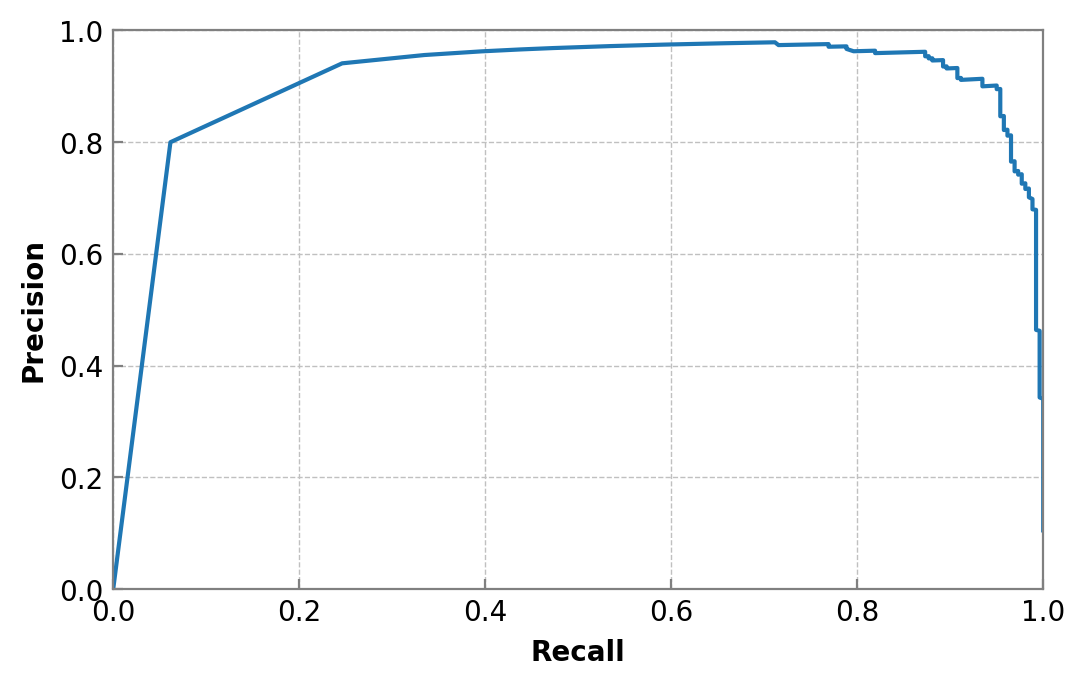

In [74]:
from matplotlib import pyplot as plt

ps, rs, ths = ([], [], [])
th = np.max(pred_es)
while th >= 0.0:
    p, r = pr_at_th(th)
    ps.append(p)
    rs.append(r)
    ths.append(th)
    th -= 0.0005
    
from sklearn import metrics

print(f'AUC: {metrics.auc(rs, ps)}, max R: {max(rs)}, max P: {max(ps)}')
    
i = len(rs) - 1
while rs[i] == 1.0:
    i -= 1
i += 1
print(f'100% recall at: {int(ps[i] * 100)}%, threshold: {ths[i]}')

fig, ax = plt.subplots(figsize=(6, 3.7), dpi=200)

ax.spines['top'].set_color('#808080')
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.spines['bottom'].set_color('#808080')
ax.tick_params(direction='in', color='#808080')

plt.grid(color='#c0c0c0', linestyle='--', linewidth=0.5)

plt.ylabel('Precision', fontweight='bold')
plt.xlabel('Recall', fontweight='bold')

plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))

_ = plt.plot(rs, ps)